In [93]:
# import fasttext
# import pandas as pd
import re

In [94]:
# # model = fasttext.train_supervised(input=TRAIN_FILEPATH, lr=1.0, epoch=100,
# #                              wordNgrams=2, bucket=200000, dim=300, loss='hs',
# #                              pretrainedVectors=VECTORS_FILEPATH)
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " 's", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " ( ", string) 
    string = re.sub(r"\)", " ) ", string) 
    string = re.sub(r"\?", " ? ", string) 
    string = re.sub(r"\s{2,}", " ", string)   
    string = re.sub(" \d+", " ", string)
    return  string.strip().lower()

In [95]:
import pandas as pd
TRAIN_FILEPATH = "../Translated/cleaned/train.csv"
TEST_FILEPATH = "../Translated/cleaned/test.csv"
SS_FILEPATH = "../data/SampleSubmission.csv"
VECTORS_FILEPATH = ""
train = pd.read_csv(TRAIN_FILEPATH)
test = pd.read_csv(TEST_FILEPATH)
ss = pd.read_csv(SS_FILEPATH)

In [96]:
# # train.Text.str.lower().str.split()
# # from collections import Counter
# # result = Counter(" ".join(train['cleaned'].values.tolist()).split(" ")).items()
# # result
train["Text"] =train.Text.apply(lambda x: clean_str(x))
test["Text"] =test.Text.apply(lambda x: clean_str(x))


In [97]:
# train.Text.str.lower().str.split().apply(len).max()
# train

In [98]:
# len(result)
# test
# result

In [99]:
# train.Text[0]
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import nltk
nltk.download('stopwords')
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
from sklearn.preprocessing import LabelBinarizer
sns.set_style("whitegrid")
np.random.seed(0)

DATA_PATH = '../data'
EMBEDDING_DIR = '../Vectors'

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amakr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [100]:
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('../Vectors/wiki.ny.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

390it [00:00, 3749.49it/s]

loading word embeddings...


1955it [00:00, 5553.81it/s]

found 1955 word vectors


In [101]:
# model = fasttext.load_model()
train[train.Label == "POLITICS"].Text[0]

'mwangonde khansala wachinyamata akamati achinyamata ndi atsogoleri a mawa , ambiri amaganiza kuti izi ndi nkhambakamwa chabe koma achinyamata ena , monga lusubilo mwangonde , akukwaniritsa akupherezetsa mawuwa osati pongolota kuti adzakhala , koma kutsogolera kumene chifukwa nthawi yawo yakwana dailes banda adacheza ndi mwangonde , khansala wachinyama , yemwe akuimira jumbo ward mumzinda wa mzuzu , motere chisale watuluka nkumangidwanso sipakala waimitsa nyumba ya malamulo pa wenela pasintha zedi ali ndi masomphenya mwangonde tikudziweni ndine lusubilo mwangonde , ndili ndi zaka  zakubadwa ndinabadwa mbanja la ana asanu ndipo ndine wachinayi kubadwa ndimachokera mmudzi mwa mwamalopa , kwa paramount chief kyungu mboma la karonga sindili pabanja pakadalipano mbiri ya maphunziro anu ndi yotani ? maphunziro anga a pulaimale ndidachitira kusukula yapulaiveti ya viphya mumzinda wa mzuzu ndipo asekondale ndidachitira pa phwezi boys mboma la rumphi ndili ndi diploma ya accounting ndipo pakada

num train:  1436
num test:  620


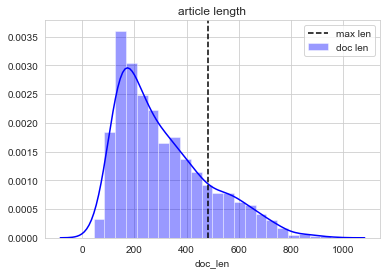

In [102]:
# dir(model)
print("num train: ", train.shape[0])
print("num test: ", test.shape[0])

label_names = train.Label.unique().tolist()
y_train = train.Label.values

# #visualize word distribution
train['doc_len'] = train['Text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train['doc_len'].mean() + train['doc_len'].std()).astype(int)
sns.distplot(train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('article length'); plt.legend()
plt.show()

In [103]:
# # model.predict(train.cleaned[0])
# model = fasttext.train_supervised(input=TRAIN_FILEPATH, lr=1.0, epoch=100,
#                              wordNgrams=2, bucket=200000, dim=300, loss='hs')
# #                              pretrainedVectors="../Vectors/wiki.ny.vec")
raw_docs_train = train['Text'].tolist()
raw_docs_test = test['Text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS+1, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

 32%|████████████████████████▊                                                    | 462/1436 [00:00<00:00, 4442.15it/s]

pre-processing train data...


100%|██████████████████████████████████████████████████████████████████████████████| 620/620 [00:00<00:00, 5537.29it/s]


tokenizing input data...
dictionary size:  63341


2843

In [105]:
# train.Text
# i
word_index

{'ndi': 1,
 'kuti': 2,
 'wa': 3,
 'ya': 4,
 'pa': 5,
 'la': 6,
 'anthu': 7,
 'ku': 8,
 'ndipo': 9,
 'za': 10,
 'kwa': 11,
 'koma': 12,
 'cha': 13,
 'ntchito': 14,
 'chifukwa': 15,
 'omwe': 16,
 'komanso': 17,
 'adati': 18,
 'ena': 19,
 'adatero': 20,
 'zomwe': 21,
 'boma': 22,
 'iye': 23,
 'ngati': 24,
 'mwa': 25,
 'mu': 26,
 'dziko': 27,
 'amene': 28,
 'izi': 29,
 'mdziko': 30,
 'wati': 31,
 'ndiye': 32,
 'bungwe': 33,
 'ali': 34,
 'malamulo': 35,
 'pomwe': 36,
 'ndalama': 37,
 'yemwe': 38,
 'muno': 39,
 'yomwe': 40,
 'bwino': 41,
 'chaka': 42,
 'nthawi': 43,
 'mboma': 44,
 'malawi': 45,
 'lino': 46,
 'pamene': 47,
 'nkhani': 48,
 'ati': 49,
 'nyumba': 50,
 'akuti': 51,
 'zina': 52,
 'zaka': 53,
 'kwambiri': 54,
 'kapena': 55,
 'monga': 56,
 'nawo': 57,
 'munthu': 58,
 'mkulu': 59,
 'momwe': 60,
 'ambiri': 61,
 'ana': 62,
 'mtsogoleri': 63,
 'wake': 64,
 'wina': 65,
 'apolisi': 66,
 'chomwe': 67,
 'chakwera': 68,
 'ngakhale': 69,
 'sukulu': 70,
 'zinthu': 71,
 'iwo': 72,
 'ake': 73,
 

In [106]:
# word_seq_train.shape
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [107]:
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 62288


In [108]:
# print("sample words not found: ", np.random.choice(words_not_found, 100))
# len(words_not_found)
lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train) 

In [109]:
# y_train_b[0]

In [110]:
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 482, 300)          19002300  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 482, 64)           134464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 241, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 241, 64)           28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3

In [111]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]
# y_train = np.asarray(y_train).reshape((-1,1))


In [112]:
hist = model.fit(word_seq_train, y_train_b, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/8
6/6 - 4s - loss: 0.6128 - accuracy: 0.0735 - val_loss: 0.4046 - val_accuracy: 0.0000e+00
Epoch 2/8
6/6 - 3s - loss: 0.4464 - accuracy: 0.0464 - val_loss: 0.3167 - val_accuracy: 0.0000e+00
Epoch 3/8
6/6 - 3s - loss: 0.3620 - accuracy: 0.0697 - val_loss: 0.2468 - val_accuracy: 0.1181
Epoch 4/8
6/6 - 3s - loss: 0.2987 - accuracy: 0.1115 - val_loss: 0.2107 - val_accuracy: 0.1944
Epoch 5/8
6/6 - 3s - loss: 0.2581 - accuracy: 0.1231 - val_loss: 0.1980 - val_accuracy: 0.1944
Epoch 6/8
6/6 - 3s - loss: 0.2416 - accuracy: 0.1354 - val_loss: 0.1930 - val_accuracy: 0.1944
Epoch 7/8
6/6 - 3s - loss: 0.2288 - accuracy: 0.1207 - val_loss: 0.1891 - val_accuracy: 0.1944
Epoch 8/8
6/6 - 3s - loss: 0.2230 - accuracy: 0.1316 - val_loss: 0.1863 - val_accuracy: 0.1944


In [ ]:
# len(train.Label.unique().tolist())
# word_seq_train.shape
# labels
a = model.predict(word_seq_test)
# word_seq_train.max()
# word_seq_test.shape

In [ ]:
# word_seq_train.shape
# a[0]
word_seq_test.max()

In [ ]:
# logits
y_train_b[0]*a[0]

In [ ]:
word_seq_train.shape

In [ ]:
y_train.shape

In [113]:
from googletrans import Translator


In [114]:
translator = Translator()
# train.Text[0]

In [116]:
# translator.translate('안녕하세요.')

In [118]:
# cleaned_train = pd.read_csv('../Translated/cleaned/train.csv')
# test.char_len.max()
# train.Text.to_csv('../Translated/train1.csv',index = False)

In [120]:
# cleaned_train.Text.to_csv('../Translated/train1.csv',index = False)
# plt.figure()
# plt.hist(test['char_len'])
# plt.show()

In [59]:
# 1436*2
train['char_len'] = train['Text'].apply(lambda x: len(str(x)))
test['char_len'] = test['Text'].apply(lambda x: len(str(x)))


In [62]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [63]:
X_dtm = vect.fit_transform(train.Text)


In [65]:
# X_dtm
test_X_dtm = vect.transform(test.Text)


In [66]:
from keras.preprocessing import text

In [67]:
tokenizer = text.Tokenizer()

In [68]:
tokenizer.fit_on_texts(train.Text)

In [74]:
a = tokenizer.texts_to_sequences(train.Text)

In [79]:
max(max(a))

49694

In [78]:
a = tokenizer.texts_to_sequences(test.Text)

In [82]:
len(set(a[0]))

170